In [1]:
import matplotlib.pyplot as plt
import src.RX as RX
import numpy as np
import cv2
import time


#### parameters that needs to be exhanged between the sender and the receiver #####
IP = "0.0.0.0"
PORT = 23422
#             #  t1  t2  t3  t4  t5  t6  t7  t8  t9
# X = np.array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0], # m1
#               [ 1,  0,  0,  0,  0,  0,  0,  1,  0], # m2
#               [ 1,  0,  0,  0,  0,  0,  0,  0,  1], # m3
#               [ 0,  1,  0,  0,  0,  0,  1,  0,  0], # m4
#               [ 0,  1,  0,  0,  0,  0,  0,  1,  0], # m5
#               [ 0,  1,  0,  0,  0,  0,  0,  0,  1], # m6
#               [ 0,  0,  1,  0,  0,  0,  1,  0,  0], # m7
#               [ 0,  0,  1,  0,  0,  0,  0,  1,  0], # m8
#               [ 0,  0,  1,  0,  0,  0,  0,  0,  1], # m9
#               [ 0,  0,  0,  1,  0,  0,  1,  0,  0], # m10
#               [ 0,  0,  0,  1,  0,  0,  0,  1,  0], # m11
#               [ 0,  0,  0,  1,  0,  0,  0,  0,  1], # m12
#               [ 0,  0,  0,  0,  1,  0,  1,  0,  0], # m13
#               [ 0,  0,  0,  0,  1,  0,  0,  1,  0], # m14
#               [ 0,  0,  0,  0,  1,  0,  0,  0,  1], # m15
#               [ 0,  0,  0,  0,  0,  1,  1,  0,  0], # m16
#               [ 0,  0,  0,  0,  0,  1,  0,  1,  0], # m17
#               [ 0,  0,  0,  0,  0,  1,  0,  0,  1]]) # m18
#             #  t1  t2  t3  t4  t5  t6  t7  t8  t9
# Y = np.array([[ 0,  0,  0,  0,  0,  0,  1,  0,  0], # m1
#               [ 0,  0,  0,  0,  0,  0,  0,  1,  0], # m2
#               [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # m3
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m4
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m5
#               [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # m6
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m7
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m8
#               [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # m9
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m10
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m11
#               [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # m12
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m13
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m14
#               [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # m15
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m16
#               [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # m17
#               [ 0,  0,  0,  0,  0,  0,  0,  0,  1]]) # m18

X = np.eye(18)
Y = np.eye(18)

chunk_size_Byte = 1024
key = b"key"
digestmod = 'sha384'



buffer = RX.Buffer(X, Y, BUFFER_SIZE_IN_PAGES = 25, TIMEOUT_SECOND = 0.00001,  warnings = True)
udp_rx = RX.UDP_RX(buffer= buffer, IP = IP, PORT = PORT, X = X, Y = Y,  chunk_size_Byte=chunk_size_Byte, KEY=key, digestmod=digestmod)

# verified_page = udp_rx.receive()
# rec, _, _ = udp_rx.process_verified_page(verified_page)
# 1/0
total_avg_verification = []
total_not_verified_cnt = []
tag_per_message_cnt = []
total_latency = []
cnt = 0

start = time.time()

while True:
    cnt += 1
    verified_page = udp_rx.receive()
    rec, avg_vericication, not_verified_cnt, tag_per_message, latency = udp_rx.process_verified_page(verified_page)
    total_avg_verification.append(avg_vericication)
    total_not_verified_cnt.append(not_verified_cnt)
    tag_per_message_cnt.append(tag_per_message)
    total_latency.append(latency)
    if rec is not None and len(rec) > 0:  # Ensure rec is not None and has valid data
        nparr = np.frombuffer(rec, np.uint8)
        
        if nparr is not None and len(nparr) > 0:  # Check if nparr is valid
            try:
                frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                
                if frame is not None:  # Ensure that the frame is successfully decoded
                    cv2.imshow('Received Video', frame)
                    
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    # print("Failed to decode frame.")
                    pass
            except Exception as e:
                # print(f"Error decoding frame: {e}")
                pass
        else:
            # print("Empty or invalid buffer received.")
            pass
    else:
        # print("Received an empty or invalid page.")
        pass
    if cnt % 100 == 0:
        print(f"avg_verification: {np.sum(total_avg_verification)/cnt}, not_verified_cnt: {np.sum(total_not_verified_cnt)}, tag_per_message: {np.sum(tag_per_message_cnt)/cnt}, latency: {np.sum(total_latency)/cnt}")
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if time.time() - start > 50:
        break
cv2.destroyAllWindows()

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 382 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2342 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2321 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 273 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 872 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data se

avg_verification: 0.9966666666666666, not_verified_cnt: 36, tag_per_message: 1.0, latency: 0.004400932614653756


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 640 extraneous bytes before

avg_verification: 0.9965277777777777, not_verified_cnt: 75, tag_per_message: 1.0, latency: 0.004338286035682065


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: p

avg_verification: 0.9964506172839506, not_verified_cnt: 115, tag_per_message: 1.0, latency: 0.004318499890258345


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: p

avg_verification: 0.9963657407407406, not_verified_cnt: 157, tag_per_message: 1.0, latency: 0.004298991187848725


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end 

avg_verification: 0.9964259259259257, not_verified_cnt: 193, tag_per_message: 1.0, latency: 0.004274880002783306


Corrupt JPEG data: 605 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1675 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 455 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 13290 extraneous bytes before marker 0x38
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1518 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature

avg_verification: 0.996305114638448, not_verified_cnt: 246, tag_per_message: 1.0, latency: 0.004342634693507873


Corrupt JPEG data: 1 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premat

avg_verification: 0.9964021164021165, not_verified_cnt: 283, tag_per_message: 1.0, latency: 0.00437623546679653


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1187 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: pre

avg_verification: 0.9963227513227512, not_verified_cnt: 331, tag_per_message: 1.0, latency: 0.004423200199807943


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xc4
Corrupt JPEG data: 377 extraneous bytes before marker 0xd9
Corrupt JPEG data: 18308 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1360 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 338 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature en

avg_verification: 0.9963727219282774, not_verified_cnt: 366, tag_per_message: 1.0, latency: 0.0044025672535089825


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1939 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 491 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG

avg_verification: 0.9963492063492063, not_verified_cnt: 408, tag_per_message: 1.0, latency: 0.004388376806940939


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1809 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG d

avg_verification: 0.9963107263107263, not_verified_cnt: 452, tag_per_message: 1.0, latency: 0.004385642998654391


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end 

avg_verification: 0.9962092151675483, not_verified_cnt: 505, tag_per_message: 1.0, latency: 0.004380113373573269


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 21098 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


avg_verification: 0.9962861212861213, not_verified_cnt: 540, tag_per_message: 1.0, latency: 0.004404678128540799


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end 

avg_verification: 0.9962944066515496, not_verified_cnt: 582, tag_per_message: 1.0, latency: 0.0044082054744088404


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1473 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 269 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG

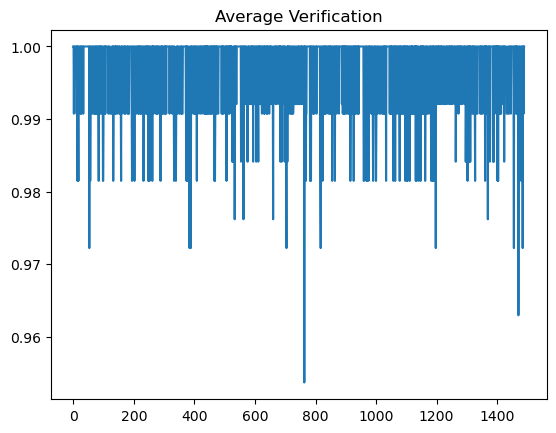

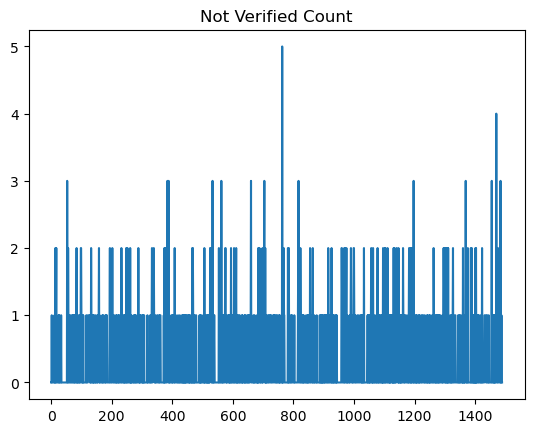

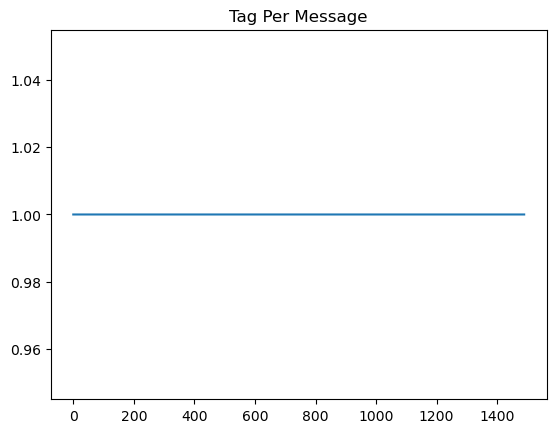

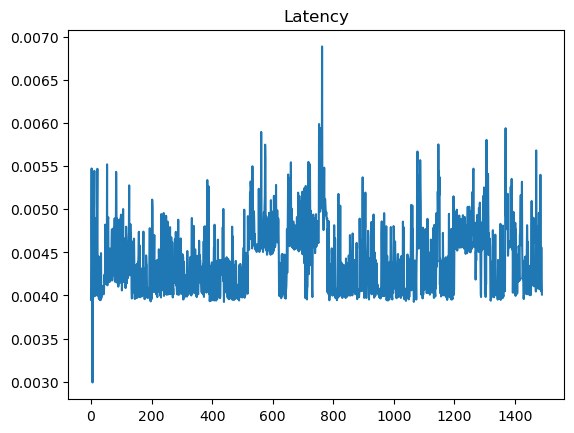

In [2]:

plt.plot(total_avg_verification)
plt.title('Average Verification')
plt.show()

plt.plot(total_not_verified_cnt)
plt.title('Not Verified Count')
plt.show()

plt.plot(tag_per_message_cnt)
plt.title('Tag Per Message')
plt.show()

plt.plot(total_latency)
plt.title('Latency')
plt.show()